In [0]:
%%shell

# Install pycocotools
git clone https://github.com/cocodataset/cocoapi.git
cd cocoapi/PythonAPI
python setup.py build_ext install

Cloning into 'cocoapi'...
remote: Enumerating objects: 965, done.
remote: Total 965 (delta 0), reused 0 (delta 0), pack-reused 965
Receiving objects: 100% (965/965), 11.72 MiB | 6.52 MiB/s, done.
Resolving deltas: 100% (570/570), done.
running build_ext
cythoning pycocotools/_mask.pyx to pycocotools/_mask.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/cocoapi/PythonAPI/pycocotools/_mask.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'pycocotools._mask' extension
creating build
creating build/common
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/pycocotools
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -I../common -I/us

In [1]:
cd/content/drive/My Drive/DocExplore Mask RCNN

/content/drive/My Drive/DocExplore Mask RCNN


In [0]:
cd/content/drive

/content/drive


we will be finetuning a pre-trained Mask R-CNN model in the DocExplore datebase for object detection and segmentation. It contains 90 images with ..... instances of objects. **texte en gras**

Defining the Dataset : 


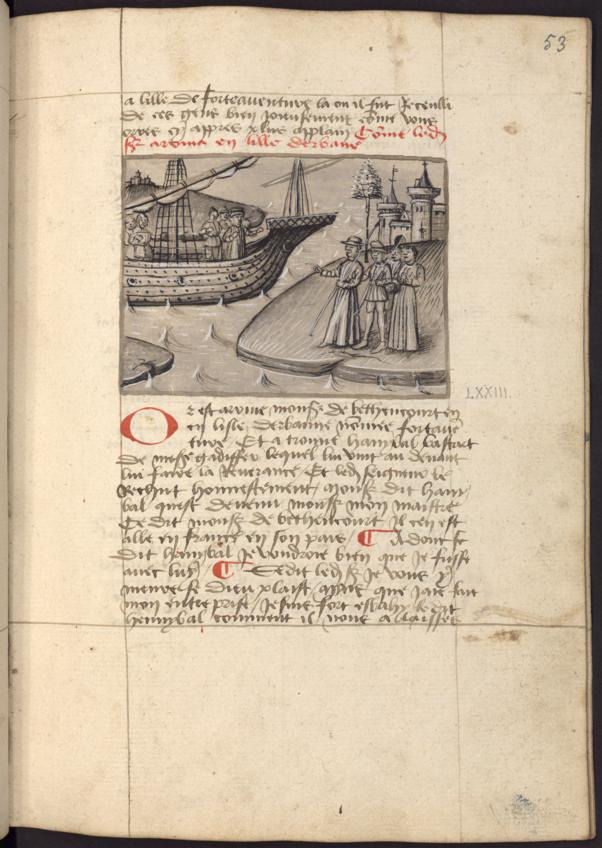

In [2]:
from PIL import Image
Image.open('DocExplore/PNGImages/page700.jpg')

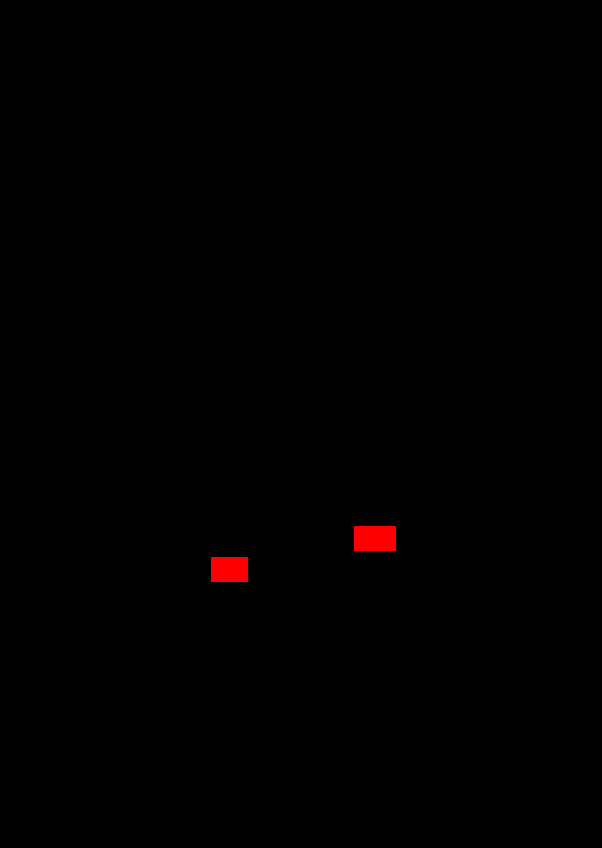

In [3]:
mask = Image.open('DocExplore/DD/page700_mask.png')
# each mask instance has a different color, from zero to N, where
# N is the number of instances. In order to make visualization easier,
# let's adda color palette to the mask.
mask.putpalette([
    0, 0, 0, # black background
    255, 0, 0, # index 1 is red
    255, 255, 0, # index 2 is yellow
    255, 153, 0, # index 3 is orange
])
mask

In [0]:
import os
import random
import time
import csv

import numpy as np

import torch
import torchvision

from PIL import Image
import cv2


%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display


from torch.autograd import Variable
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

import transforms as T

from engine import train_one_epoch, evaluate
import utils



# from torchvision import transforms
# transform = transforms.Compose([transforms.ToTensor()])  # Convert image to PyTorch Tensor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

[[211, 557, 37, 25], [354, 526, 42, 25]]


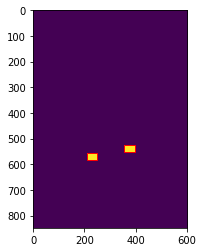

In [5]:
import numpy as np
from PIL import Image
import cv2
import csv
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display

mask_path = 'DocExplore/DD/page700_mask.png'
box_csv = 'DocExplore/Bbox/page700.csv'
mask = Image.open(mask_path)
mask = np.array(mask)

plt.imshow(mask)
with open(box_csv, 'r') as f:
    reader = csv.reader(f)
    boxes = list(reader)
final_boxes = []
for box in boxes:
    x = int(box[0])
    y = int(box[1])
    width = int(box[2])
    height = int(box[3])
    if width == 0 or height == 0:
        continue
    else:
        final_boxes.append([x,y,width,height])
        plt.gca().add_patch(Rectangle((x,y),width,height,linewidth=1,edgecolor='r',facecolor='none'))
print(final_boxes) 
plt.show()


In [0]:
import os
import numpy as np
import torch
import torch.utils.data
from PIL import Image


class DocExploreDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "DD"))))
        self.boxes = list(sorted(os.listdir(os.path.join(root, "Bbox"))))
    def __getitem__(self, idx):
        # load images ad masks
        img_path = os.path.join(self.root, "PNGImages/", self.imgs[idx])
        mask_path = os.path.join(self.root, "DD/", self.masks[idx])
        box_path = os.path.join(self.root, "Bbox/", self.boxes[idx])
        img = Image.open(img_path).convert("RGB")
        # note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance
        # with 0 being background
        mask = Image.open(mask_path)
        plt.imshow(mask)
       
        mask = np.array(mask)
       # print(mask.shape)
        with open(box_path, 'r') as f:
            reader = csv.reader(f)
            boxes = list(reader) 
            #print(boxes)   
        final_boxes = []
        for box in boxes:
            x = int(box[0])
            y = int(box[1])
            width = int(box[2])
            height = int(box[3])
            if x <= 0:
                x+=1
            if y <= 0:
                y+=1
            if x+width == 1280:
                x-=1
            if y+height == 720:
                y-=1    
            if width < 20 or height < 20:
                continue
            elif x + width > 1280 or y + height > 720:
                continue
            else:
                final_boxes.append([x,y,x+width,y+height])
        masks = np.zeros((len(final_boxes),720,1280))
       # print(masks.shape)
        for fb in range(len(final_boxes)):
           # print(fb)
            box = final_boxes[fb]
            xmin = box[0]
            xmax = box[2]
            ymin = box[1]
            ymax = box[3]
            #print(masks.shape)
            #print(mask.shape)
           
            masks[fb][ymin:ymax,xmin:xmax] = mask[ymin:ymax,xmin:xmax]
            
            masks[fb] = np.where(masks[fb] > 0, 1, 0)
                
        boxes = torch.as_tensor(final_boxes, dtype=torch.float32)
        labels = torch.ones((len(final_boxes),), dtype=torch.int64)
        image_id = torch.tensor([idx])
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        iscrowd = torch.zeros((len(final_boxes),), dtype=torch.int64)
        
        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            try:
                img, target = self.transforms(img, target)
            except:
                print("problem at " + img_path)

        return img, target

    def __len__(self):
        return len(self.imgs)

In [0]:
cd/content/drive/My Drive/DocExplore Mask RCNN/engine.py

[Errno 20] Not a directory: '/content/drive/My Drive/DocExplore Mask RCNN/engine.py'
/content/drive/My Drive/DocExplore Mask RCNN


In [0]:
def get_model_instance_segmentation(num_classes):
    # load an instance segmentation model pre-trained pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [0]:
def get_transform(train):
    transforms = []
    transforms.append(T.ToTensor())
    return T.Compose(transforms)

In [0]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [0]:
# our dataset has two classes only - background and hand
num_classes = 3
# use our dataset and defined transformations
dataset = DocExploreDataset('DocExplore', get_transform(train=True))
dataset_test = DocExploreDataset('DocExplore', get_transform(train=False))
# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=1,
    collate_fn=collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=1,
    collate_fn=collate_fn)

[['274', '130', '41', '21'], ['409', '262', '59', '23'], ['202', '231', '55', '26'], ['367', '499', '54', '20'], ['266', '608', '45', '26'], ['251', '364', '57', '24'], ['427', '178', '38', '24']]


(tensor([[[0.4353, 0.4627, 0.3176,  ..., 0.1725, 0.1725, 0.1725],
          [0.5373, 0.5412, 0.3294,  ..., 0.1686, 0.1804, 0.1804],
          [0.5922, 0.5490, 0.3412,  ..., 0.1647, 0.1843, 0.1843],
          ...,
          [0.0510, 0.0549, 0.0471,  ..., 0.1725, 0.1725, 0.1725],
          [0.0510, 0.0549, 0.0471,  ..., 0.1725, 0.1765, 0.1765],
          [0.0510, 0.0549, 0.0471,  ..., 0.1765, 0.1804, 0.1804]],
 
         [[0.3569, 0.3882, 0.2471,  ..., 0.1647, 0.1647, 0.1647],
          [0.4588, 0.4706, 0.2588,  ..., 0.1608, 0.1725, 0.1725],
          [0.5176, 0.4784, 0.2706,  ..., 0.1569, 0.1765, 0.1765],
          ...,
          [0.0275, 0.0314, 0.0353,  ..., 0.1647, 0.1647, 0.1647],
          [0.0275, 0.0314, 0.0353,  ..., 0.1647, 0.1686, 0.1686],
          [0.0275, 0.0314, 0.0353,  ..., 0.1686, 0.1725, 0.1725]],
 
         [[0.3137, 0.3608, 0.2392,  ..., 0.1765, 0.1765, 0.1765],
          [0.4157, 0.4314, 0.2510,  ..., 0.1725, 0.1843, 0.1843],
          [0.4627, 0.4392, 0.2549,  ...,

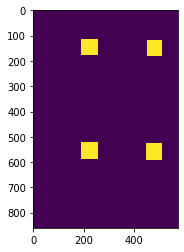

In [13]:
dataset[0]

In [0]:
# Helper functions to draw predictions:

import torchvision.transforms as T
def plot_mask_rcnn_result(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask  


def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img.to(device)])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [i for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]  
    return masks, pred_boxes, pred_class      

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth


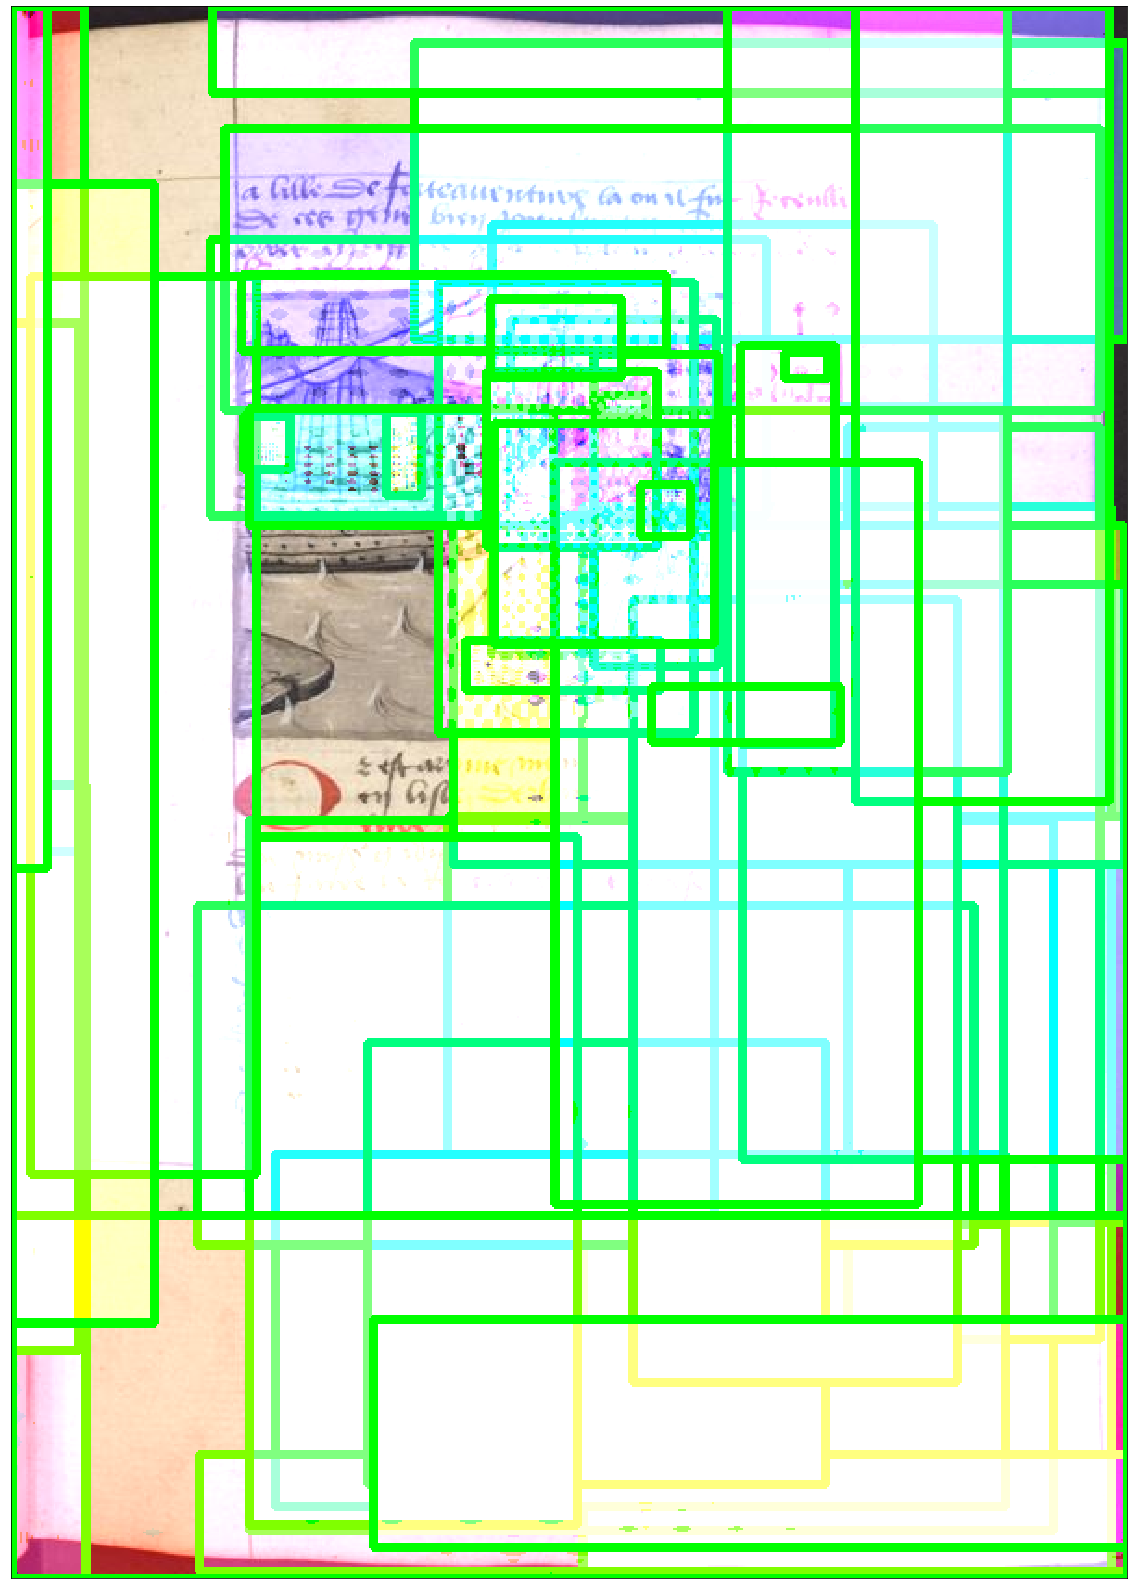

In [13]:

model = get_model_instance_segmentation(num_classes)
model.to(device)
model.eval()
plot_mask_rcnn_result('DocExplore/PNGImages/page700.jpg', threshold=0.5)

In [16]:
model = get_model_instance_segmentation(num_classes)
model.to(device)
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=0.005)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,step_size=3,gamma=0.1)
num_epochs = 20
for epoch in range(num_epochs):
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    lr_scheduler.step()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-16-bdbbb020577e>", line 8, in <module>
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  File "/content/drive/My Drive/DocExplore Mask RCNN/engine.py", line 26, in train_one_epoch
    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
  File "/content/drive/My Drive/DocExplore Mask RCNN/utils.py", line 211, in log_every
    for obj in iterable:
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 345, in __next__
    data = self._next_data()
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 856, in _next_data
    return self._process_data(data)
  File "/usr/local/lib/python3.6/dist-packages/torch/utils/data/dataloader.py", line 881, in _process_

OSError: ignored

In [0]:
num_classes=3
state_dict = torch.load('finetuned_19.pth')
model.load_state_dict(state_dict)
# move model to the right device
model.to(device)
model.eval();

In [0]:
plot_mask_rcnn_result('DocExplore_Test/page1.jpg', threshold=0.9)

IndexError: ignored

In [0]:
dataset = DocExploreDataset('DocExplore/')
dataset[20]

(<PIL.Image.Image image mode=RGB size=568x872 at 0x7FE6CBADC048>,
 {'boxes': tensor([[356.,  81., 413., 140.],
          [ 59.,  77., 117., 136.]]),
  'image_id': tensor([20]),
  'iscrowd': tensor([0, 0]),
  'labels': tensor([1, 1]),
  'masks': tensor([[[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]],
  
          [[0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           ...,
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0],
           [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)})

In [0]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

      
def get_instance_segmentation_model(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    # get the number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    # now get the number of input features for the mask classifier
    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    # and replace the mask predictor with a new one
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [0]:
from engine import train_one_epoch, evaluate
import utils
import transforms as T


def get_transform(train):
    transforms = []
    # converts the image, a PIL image, into a PyTorch Tensor
    transforms.append(T.ToTensor())
    if train:
        # during training, randomly flip the training images
        # and ground-truth for data augmentation
        transforms.append(T.RandomHorizontalFlip(0.5))
    return T.Compose(transforms)

In [0]:
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
dataset = DocExploreDataset('DocExplore', get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
 dataset, batch_size=2, shuffle=True, num_workers=4,
 collate_fn=utils.collate_fn)
# For Training
images,targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images,targets)   # Returns losses and detections
# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)           # Returns predictions

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-19-cc89e74e86bf>", line 2, in <module>
    dataset = DocExploreDataset('DocExplore', get_transform(train=True))
  File "<ipython-input-13-f778ceccfc7f>", line 14, in __init__
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
OSError: [Errno 107] Transport endpoint is not connected: 'DocExplore/PNGImages'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/py

OSError: ignored

In [0]:
# use our dataset and defined transformations
dataset = DocExploreDataset('DocExplore', get_transform(train=True))
dataset_test = DocExploreDataset('DocExplore', get_transform(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 2882, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-20-36c5c742483c>", line 1, in <module>
    dataset = DocExploreDataset('DocExplore', get_transform(train=True))
  File "<ipython-input-13-f778ceccfc7f>", line 14, in __init__
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
OSError: [Errno 107] Transport endpoint is not connected: 'DocExplore/PNGImages'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py", line 1823, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'OSError' object has no attribute '_render_traceback_'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/py

OSError: ignored

In [0]:
dataset[0]

(tensor([[[0.1686, 0.1647, 0.1608,  ..., 0.0510, 0.0510, 0.0980],
          [0.1647, 0.1608, 0.1569,  ..., 0.0667, 0.1412, 0.2667],
          [0.1608, 0.1569, 0.1529,  ..., 0.1490, 0.2980, 0.4824],
          ...,
          [0.1843, 0.1882, 0.1922,  ..., 0.0588, 0.0667, 0.0667],
          [0.1843, 0.1882, 0.1961,  ..., 0.0471, 0.0471, 0.0510],
          [0.1882, 0.1922, 0.2000,  ..., 0.0510, 0.0510, 0.0588]],
 
         [[0.1490, 0.1451, 0.1412,  ..., 0.0157, 0.0157, 0.0588],
          [0.1451, 0.1412, 0.1373,  ..., 0.0314, 0.1059, 0.2314],
          [0.1412, 0.1373, 0.1333,  ..., 0.1137, 0.2627, 0.4471],
          ...,
          [0.1490, 0.1529, 0.1569,  ..., 0.0353, 0.0314, 0.0314],
          [0.1490, 0.1529, 0.1608,  ..., 0.0275, 0.0275, 0.0275],
          [0.1451, 0.1490, 0.1608,  ..., 0.0431, 0.0431, 0.0392]],
 
         [[0.1725, 0.1686, 0.1647,  ..., 0.0353, 0.0353, 0.0902],
          [0.1686, 0.1647, 0.1608,  ..., 0.0431, 0.1255, 0.2510],
          [0.1647, 0.1608, 0.1569,  ...,

In [0]:
import torchvision.transforms as T
def plot_mask_rcnn_result(img_path, threshold=0.5, rect_th=3, text_size=3, text_th=3):
    masks, boxes, pred_cls = get_prediction(img_path, threshold)
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    for i in range(len(masks)):
        rgb_mask = random_colour_masks(masks[i])
        img = cv2.addWeighted(img, 1, rgb_mask, 0.5, 0)
        cv2.rectangle(img, boxes[i][0], boxes[i][1],color=(0, 255, 0), thickness=rect_th)
    plt.figure(figsize=(20,30))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    plt.show()
 
def random_colour_masks(image):
    colours = [[0, 255, 0],[0, 0, 255],[255, 0, 0],[0, 255, 255],[255, 255, 0],[255, 0, 255],[80, 70, 180],[250, 80, 190],[245, 145, 50],[70, 150, 250],[50, 190, 190]]
    r = np.zeros_like(image).astype(np.uint8)
    g = np.zeros_like(image).astype(np.uint8)
    b = np.zeros_like(image).astype(np.uint8)
    r[image == 1], g[image == 1], b[image == 1] = colours[random.randrange(0,10)]
    coloured_mask = np.stack([r, g, b], axis=2)
    return coloured_mask  
def get_prediction(img_path, threshold):
    img = Image.open(img_path)
    transform = T.Compose([T.ToTensor()])
    img = transform(img)
    pred = model([img.to(device)])
    pred_score = list(pred[0]['scores'].detach().cpu().numpy())
    pred_t = [pred_score.index(x) for x in pred_score if x>threshold][-1]
    masks = (pred[0]['masks']>0.5).squeeze().detach().cpu().numpy()
    pred_class = [i for i in list(pred[0]['labels'].cpu().numpy())]
    pred_boxes = [[(i[0], i[1]), (i[2], i[3])] for i in list(pred[0]['boxes'].detach().cpu().numpy())]
    masks = masks[:pred_t+1]
    pred_boxes = pred_boxes[:pred_t+1]
    pred_class = pred_class[:pred_t+1]  
    return masks, pred_boxes, pred_class

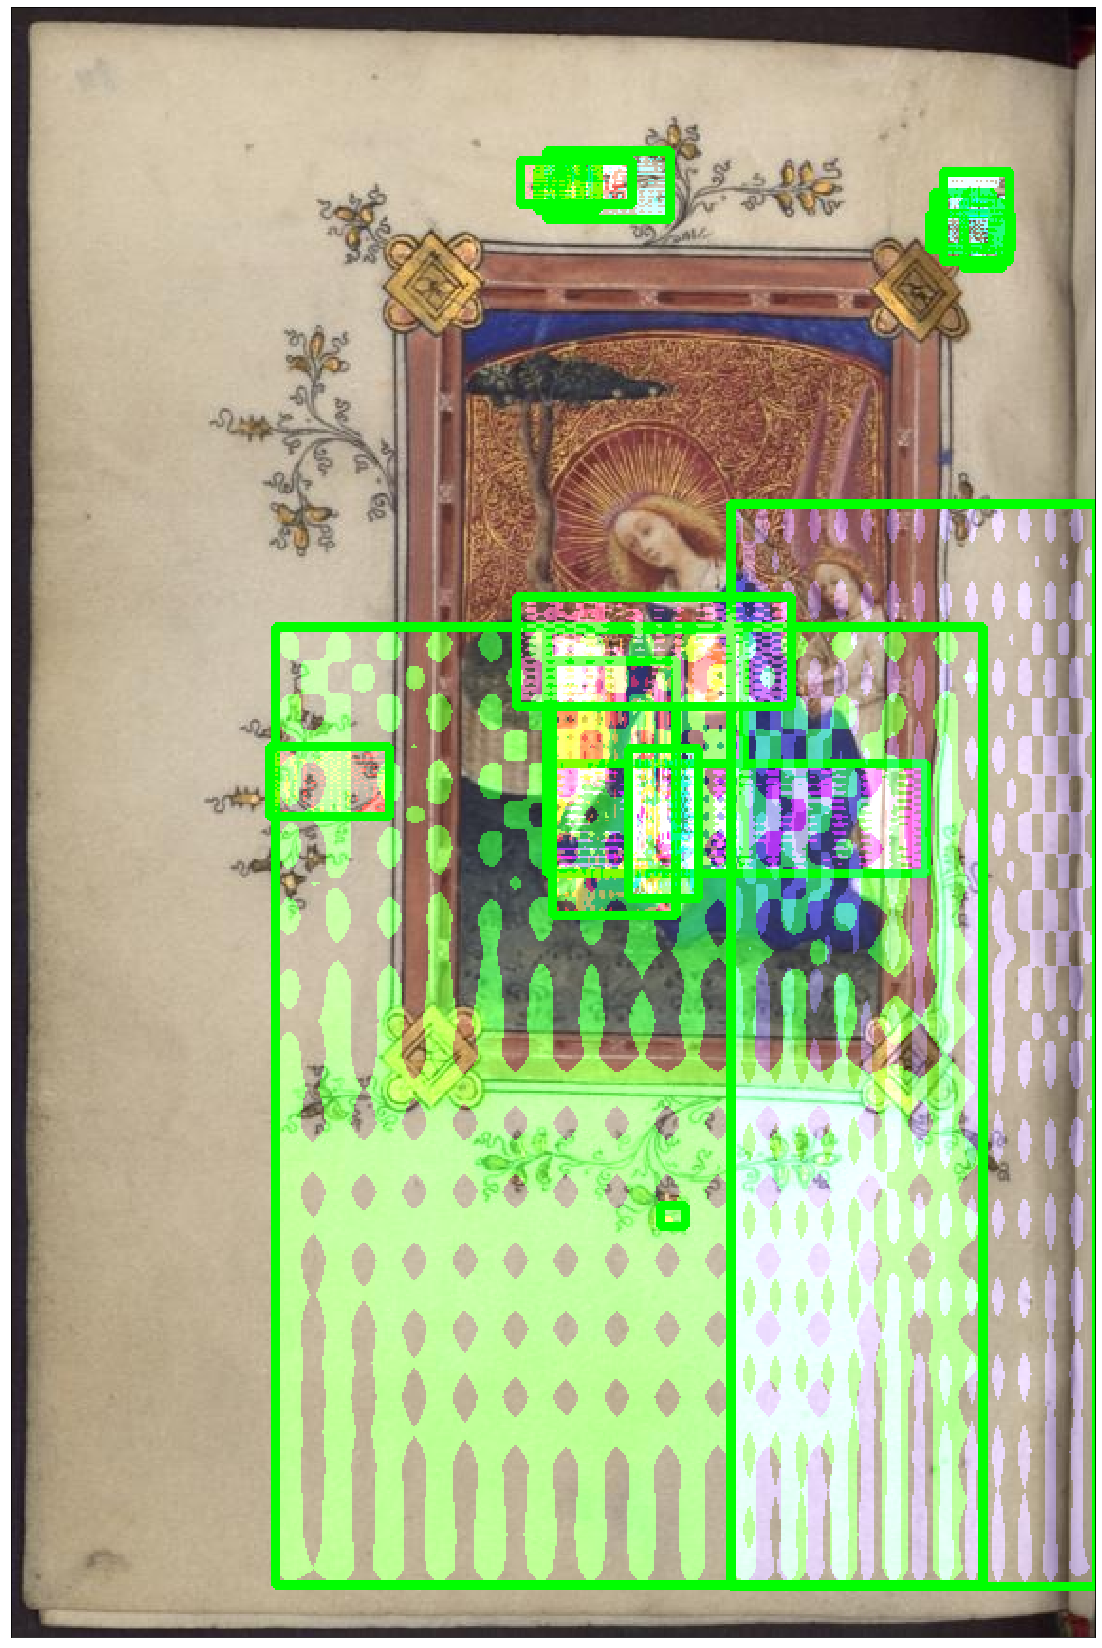

In [0]:
import cv2
import random
import time 
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from IPython import display
# transform = transforms.Compose([transforms.ToTensor()])  # Convert image to PyTorch Tensor
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model = get_instance_segmentation_model(3)
model.to(device)
model.eval()
plot_mask_rcnn_result('DocExplore/PNGImages/page225.jpg',threshold=0.6)

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 3

# get the model using our helper function
model = get_instance_segmentation_model(num_classes)
# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [0]:
# let's train it for 10 epochs
num_epochs = 10

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [ 0/20]  eta: 0:00:33  lr: 0.000268  loss: 1.2574 (1.2574)  loss_classifier: 0.8858 (0.8858)  loss_box_reg: 0.0245 (0.0245)  loss_mask: 0.3180 (0.3180)  loss_objectness: 0.0127 (0.0127)  loss_rpn_box_reg: 0.0165 (0.0165)  time: 1.6661  data: 0.6911  max mem: 2311
Epoch: [0]  [10/20]  eta: 0:00:38  lr: 0.002897  loss: 0.8373 (1.1674)  loss_classifier: 0.1279 (0.3597)  loss_box_reg: 0.0303 (0.0305)  loss_mask: 0.4083 (0.7009)  loss_objectness: 0.0687 (0.0650)  loss_rpn_box_reg: 0.0110 (0.0114)  time: 3.8925  data: 0.0681  max mem: 2750
Epoch: [0]  [19/20]  eta: 0:00:03  lr: 0.005000  loss: 0.5474 (0.8688)  loss_classifier: 0.1112 (0.2418)  loss_box_reg: 0.0303 (0.0336)  loss_mask: 0.3180 (0.5146)  loss_objectness: 0.0548 (0.0673)  loss_rpn_box_reg: 0.0110 (0.0116)  time: 3.6155  data: 0.0410  max mem: 2750
Epoch: [0] Total time: 0:01:12 (3.6254 s / it)
creating index...
index created!
Test:  [ 0/50]  eta: 0:00:40  model_time: 0.1964 (0.1964)  evaluator_time: 0.1029 (0.1029)  

In [0]:
# pick one image from the test set
img, _ = dataset_test[0]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])

In [0]:
prediction

[{'boxes': tensor([[170.3746,  31.4361, 460.5907, 543.5292],
          [149.0677, 246.8296, 496.8842, 612.0261],
          [143.0204,   0.0000, 498.7368, 333.0459],
          [ 74.8477, 129.5110, 363.4587, 642.1043],
          [174.2650, 316.6666, 516.2258, 854.0000],
          [ 48.7954,  45.8831, 397.1304, 424.1139],
          [247.3307, 125.4862, 547.7474, 663.9539],
          [ 64.3043, 430.5669, 534.6328, 708.4323],
          [153.5933, 105.7114, 585.5424, 391.3853],
          [183.6768,   3.2658, 527.1280, 496.6169],
          [ 91.9018, 576.6035, 557.4336, 840.9284],
          [ 77.5534, 308.1540, 376.6683, 841.1672],
          [175.6375, 330.5518, 514.7054, 847.0585],
          [146.5922, 254.6910, 501.6087, 609.3900],
          [ 69.8077, 194.8345, 572.4542, 477.1375],
          [259.9861, 283.1135, 426.3036, 464.7628],
          [186.8573, 503.7461, 441.9987, 653.3922],
          [242.0292, 311.7474, 373.8268, 559.7851],
          [249.3458, 176.4945, 370.8943, 421.7958],
   

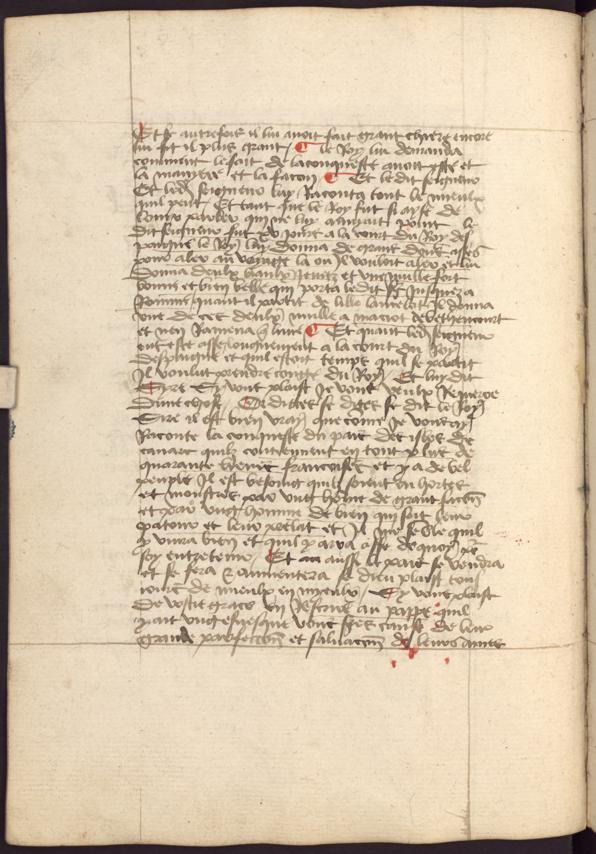

In [0]:
Image.fromarray(img.mul(255).permute(1, 2, 0).byte().numpy())

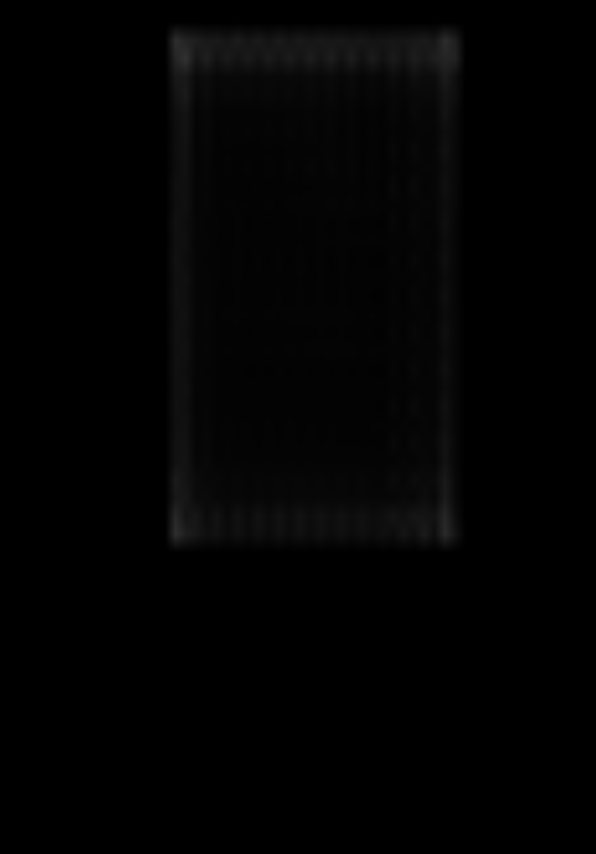

In [0]:
Image.fromarray(prediction[0]['masks'][0, 0].mul(255).byte().cpu().numpy())